<a href="https://colab.research.google.com/github/SlopeStriker/Python_Training/blob/Israelsen_Python_Fundamentals/Batch_Processing_Times_JP_Prod_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer Churn

"Customer churn" is a term used to describe when a company loses customers.  The example in this notebook involves a scenario familiar to many: switching mobile phone providers.  If my provider could identify my intent to switch early, it could entice me to stay with timely offers, such as a phone upgrade or a new service feature.

Machine learning can help us identify patterns in the data for customers who left in the past, thus helping us prevent the same churn in the future.

The data for this notebook is included in `churn.csv`.

# 1. Setup

Import the necessary libraries.  NOTE: If you're using an environment other than Google Colab, you may need to first install some of these using `!pip`.
*   **pandas**: A library for organizing and manipulating data, making it easy to work with tables.
*   **numpy**: A library for numerical computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
*   **matplotlib**: A plotting library for Python, used to create static, animated, and interactive graphs and charts.
*   **seaborn**: A statistical data visualization library built on top of matplotlib, offering a higher-level interface for drawing statistical graphics.
*   **xgboost**: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable, used for building machine learning models, especially for solving data science challenges involving structured data.





In [1]:
# If you need to install libraries, you can do so using this syntax
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 2. Data Cleansing and Exploratory Data Analysis

It all starts with data.  Load the data from churn.csv into a DataFrame, then explore and visualize it to help us better understand what we're working with, and what will be most important to pass to the model when we train it.

In [60]:
# LOAD THE DATA

# We'll use pandas to load the CSV data into a DataFrame
# If using Google Colab, the file should be uploaded to /content folder
Batch_data = pd.read_csv('20240623_JP_Prod_Batch_Job_Execution_Extract.csv')

# Display the first five rows of the dataset to understand its structure
Batch_data.head()

,Scheduler_Process_Description,Job_ID,Started,Finished,Duration_In_Minutes,Status,Result,ExecutionDate,BatchType,RunBy
0,SOD Contract Status Update,93,4/23/2023 3:01,4/23/2023 3:12,11.33,Completed,Successful,4/23/2023 0:00,SOD1,System
1,SOD Contract Balance Update,250,4/23/2023 3:13,4/23/2023 3:17,4.08,Completed,Successful,4/23/2023 0:00,SOD1,System
2,SOD CF Asset Balance History Update,328,4/23/2023 3:17,4/23/2023 3:19,1.83,Completed,Successful,4/23/2023 0:00,SOD1,System
3,SOD Update Batch Run Date,75,4/23/2023 3:21,4/23/2023 3:21,0.00,Completed,Successful,4/23/2023 0:00,SOD1,System
4,SOD Update Collection Status,76,4/23/2023 3:21,4/23/2023 3:21,0.37,Completed,Successful,4/23/2023 0:00,SOD1,System


In [61]:
# @title Default title text
# CLEAN THE DATA
# Standardize data for boolean columns, making everything "True" or "False"
Batch_data["Result"] = Batch_data["Result"].map({'Successful': True, 'Failed': False, 'Intraday-Running': False, 'None': False, 'Queued': False, 'Successful Nothing Processed': True, 'Warning': True})
Batch_data["Status"] = Batch_data["Status"].map({'Completed': True, 'Failed': False, 'Not Required': True, 'Not Run': False, 'Started': True})

# Check for missing values
# If there are any missing values, you can fill them with a placeholder or drop them, depending on the context
# We don't actually have missing values in this dataset, we'll just print
print(Batch_data.isnull().sum())
#Count amount of values in Dataframe
print(Batch_data.count())


Scheduler_Process_Description      0
Job_ID                             0
Started                          504
Finished                         504
Duration_In_Minutes                0
Status                             0
Result                           523
ExecutionDate                      0
BatchType                          0
RunBy                            504
dtype: int64
Scheduler_Process_Description    48806
Job_ID                           48806
Started                          48302
Finished                         48302
Duration_In_Minutes              48806
Status                           48806
Result                           48283
ExecutionDate                    48806
BatchType                        48806
RunBy                            48302
dtype: int64


In [62]:
# Removing empty values and then checking again for the status
Batch_data.dropna(inplace=True)
print(Batch_data.isnull().sum())
#Count amount of values in Dataframe
print(Batch_data.count())

Scheduler_Process_Description    0
Job_ID                           0
Started                          0
Finished                         0
Duration_In_Minutes              0
Status                           0
Result                           0
ExecutionDate                    0
BatchType                        0
RunBy                            0
dtype: int64
Scheduler_Process_Description    48283
Job_ID                           48283
Started                          48283
Finished                         48283
Duration_In_Minutes              48283
Status                           48283
Result                           48283
ExecutionDate                    48283
BatchType                        48283
RunBy                            48283
dtype: int64


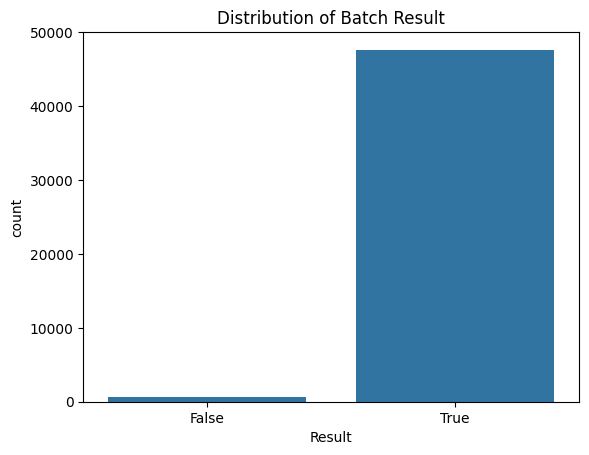

Percentage of batch jobs completing successful: 98.70%


In [63]:
# EXPLORE AND VISUALIZE THE DATA

# Visualize the distribution of customer churn
sns.countplot(x='Result', data=Batch_data)
plt.title('Distribution of Batch Result')
plt.show()

# Calculate the percentage of churn
Result_percentage = Batch_data['Result'].value_counts('Successful') * 100
# Print the percentage of Batch jobs completing successful
print(f"Percentage of batch jobs completing successful: {Result_percentage[0]:.2f}%")

There is some imbalance in the data, as most batches have completed successful.

,Job_ID,Duration_In_Minutes
count,48283.000000,48283.000000
mean,284.729698,7.616185
std,131.722591,56.589936
min,1.000000,0.000000
25%,240.000000,0.020000
50%,315.000000,0.100000
75%,378.000000,0.550000
max,564.000000,1099.230000


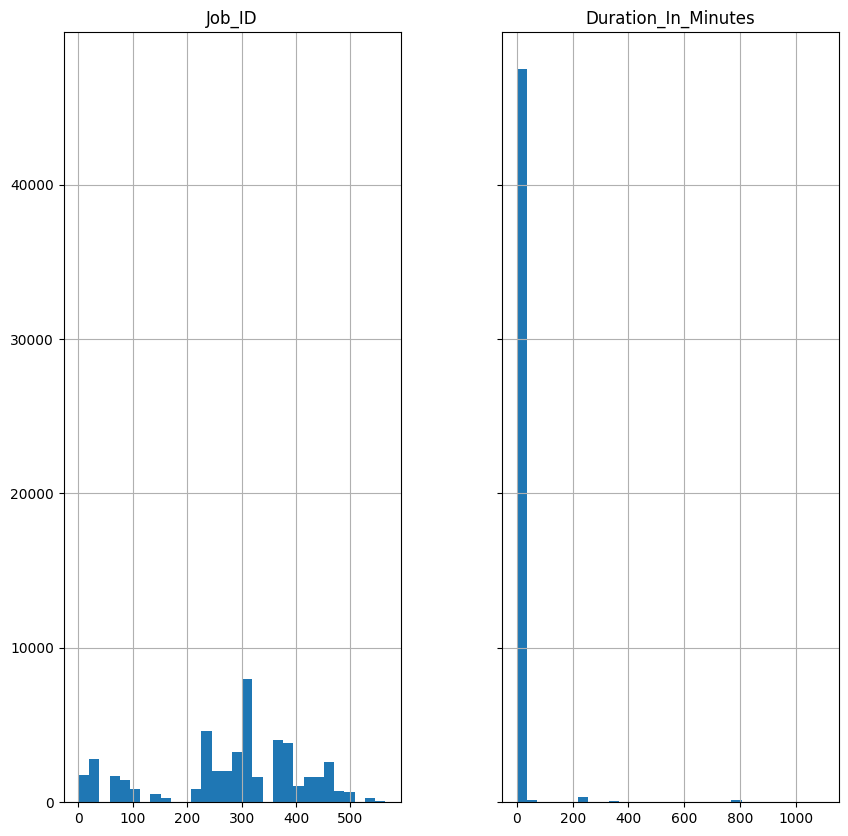

In [64]:
# Histograms for each numeric features, to see how balanced the data is
display(Batch_data.describe())
%matplotlib inline
hist = Batch_data.hist(bins=30, sharey=True, figsize=(10, 10))

The numeric features are not well balanced and are not showing a bell-shaped (or Gaussian) distribution.  In machine learning, this normality is desired for optimal performance of the algorithms.  Columns 'JobId` will be handle below.

In [65]:
# Frequency tables for each categorical feature
for column in Batch_data.select_dtypes(include=['object', 'bool']).columns:
    # Using 'display' to show the DataFrame and 'pd.crosstab()' to create the frequency table
    display(column, pd.crosstab(index=Batch_data[column], columns='% observations', normalize='columns') * 100)  # Multiplying by 100 to convert to percentage

'Scheduler_Process_Description'

col_0,% observations
Scheduler_Process_Description,
Ad hoc CF Invoice Generation,0.004142
Ad hoc EOM Update Floating Rate,0.055920
Ad hoc Miscellaneous Invoice,0.004142
Ad hoc Miscellaneous Invoice - Dealer,0.004142
Ad hoc Output Email 2,0.004142
...,...
SOD Update Floating Rate,0.886440
SOD Update Retail Workflow Status,0.447362
Weekly DT RF JP AII Missing Physical Document,0.066276


'Started'

col_0,% observations
Started,
1/1/2024 10:00,0.002071
1/1/2024 11:00,0.004142
1/1/2024 11:30,0.004142
1/1/2024 11:50,0.002071
1/1/2024 11:51,0.002071
...,...
9/9/2023 7:23,0.002071
9/9/2023 7:26,0.002071
9/9/2023 7:40,0.002071


'Finished'

col_0,% observations
Finished,
1/1/2024 10:00,0.002071
1/1/2024 11:00,0.004142
1/1/2024 11:50,0.004142
1/1/2024 11:51,0.002071
1/1/2024 11:52,0.002071
...,...
9/9/2023 7:26,0.002071
9/9/2023 7:27,0.002071
9/9/2023 7:40,0.002071


'Status'

col_0,% observations
Status,
False,0.501212
True,99.498788


'Result'

col_0,% observations
Result,
False,1.302736
True,98.697264


'ExecutionDate'

col_0,% observations
ExecutionDate,
1/1/2024 0:00,0.234037
1/10/2024 0:00,0.316882
1/11/2024 0:00,0.314811
1/12/2024 0:00,0.312739
1/13/2024 0:00,0.283744
...,...
9/5/2023 0:00,0.165690
9/6/2023 0:00,0.167761
9/7/2023 0:00,0.161548


'BatchType'

col_0,% observations
BatchType,
Adhoc,6.886482
EOD,10.107077
EOM,0.977570
Intraday,34.600170
Monthly,1.294451
SOD1,26.435806
SOD2,19.499617
Weekly,0.198828


'RunBy'

col_0,% observations
RunBy,
Anand Patil,0.202970
Babu Kiran,0.242321
Bhuvaneswaran Rathinasamy,0.006213
Fukushi Yukari,0.022782
Furuya Noriko,0.002071
G Asokan,0.171903
G Ranganathan,0.511567
Imai Miki,0.018640
Ishii Nobuya,0.041422


In [66]:
# Drop Area Code and Phone from the dataset
# Batch_data = Batch_data.drop(['Job_ID'], axis=1)

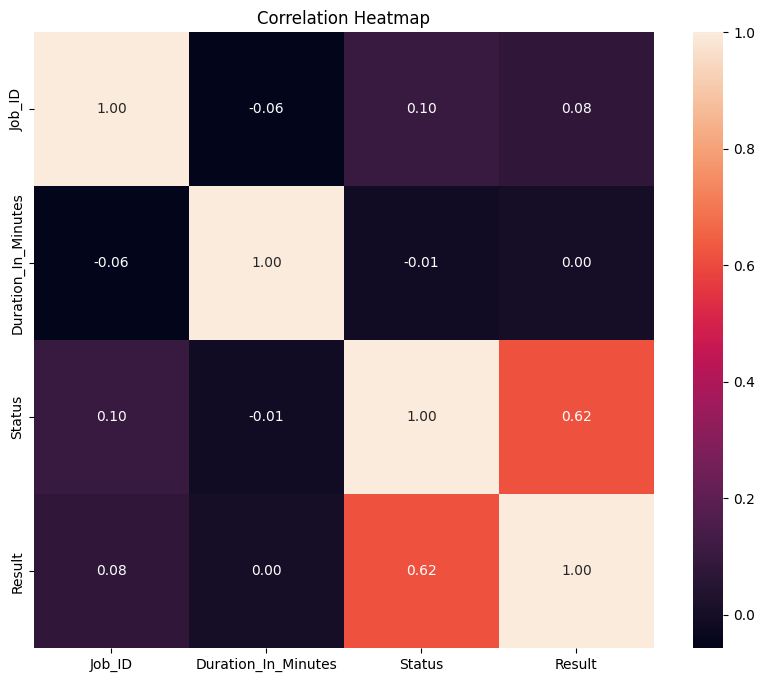

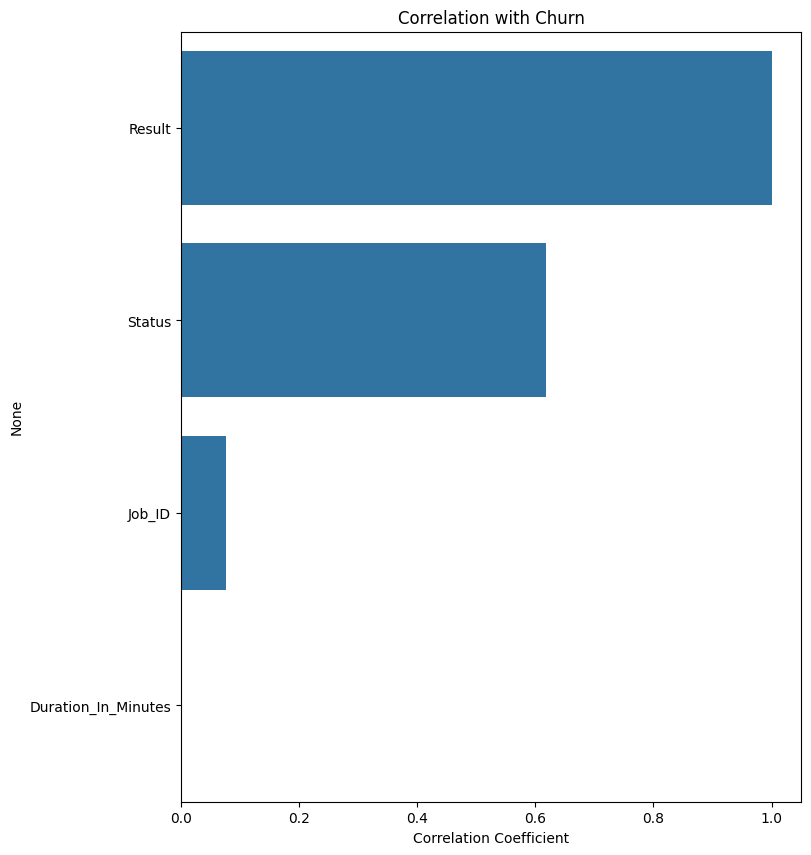

Result                 1.000000
Status                 0.617769
Job_ID                 0.076094
Duration_In_Minutes    0.002254
Name: Result, dtype: float64

In [68]:
# Two options to help visualize the correlation between features and Churn (heatmap and correlation matrix)
# Dropping column 'State' in DataFrame to ensure that heatmap function is working.
relevant_columns = Batch_data
relevant_columns = relevant_columns.drop(["Started", "Finished", "ExecutionDate", "Scheduler_Process_Description", "RunBy", "BatchType"], axis=1)
correlation_matrix = relevant_columns.corr()

# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Calculate the correlation matrix, focusing on the Churn column
Batch_Data_correlations = correlation_matrix["Result"].sort_values(ascending=False)

# Plotting the correlations with Churn
plt.figure(figsize=(8, 10))
sns.barplot(x=Batch_Data_correlations.values, y=Batch_Data_correlations.index)
plt.title("Correlation with Churn")
plt.xlabel("Correlation Coefficient")
plt.show()

Batch_Data_correlations

This exploration tells us:

*   `Int'l Plan`: There's a positive correlation (0.26) between having an international plan and churn, suggesting customers with international plans are more likely to churn. This could be due to various factors such as cost, satisfaction with international service, or other reasons that warrant further investigation.

*   `CustServ Calls`: The number of customer service calls is positively correlated (0.21) with churn, indicating that customers who contact customer service more frequently are more likely to leave. This might reflect issues with service satisfaction or unresolved problems.

*   `Day Mins` and `Day Charge`: Both of these features show a positive correlation (about 0.21) with churn, suggesting that higher day time usage (and the associated charges) could be a factor in customers' decision to churn.

*   `VMail Plan` and `VMail Message`: These features are negatively correlated with churn (-0.10 and -0.09, respectively), indicating that customers who use voicemail services are less likely to churn. This could be interpreted as an indicator of customer engagement or satisfaction with the service.

*   `Intl Calls`: Interestingly, the number of international calls is negatively correlated (-0.05) with churn, which might suggest that customers making more international calls are less likely to leave, contrasting with the positive correlation seen with having an international plan.


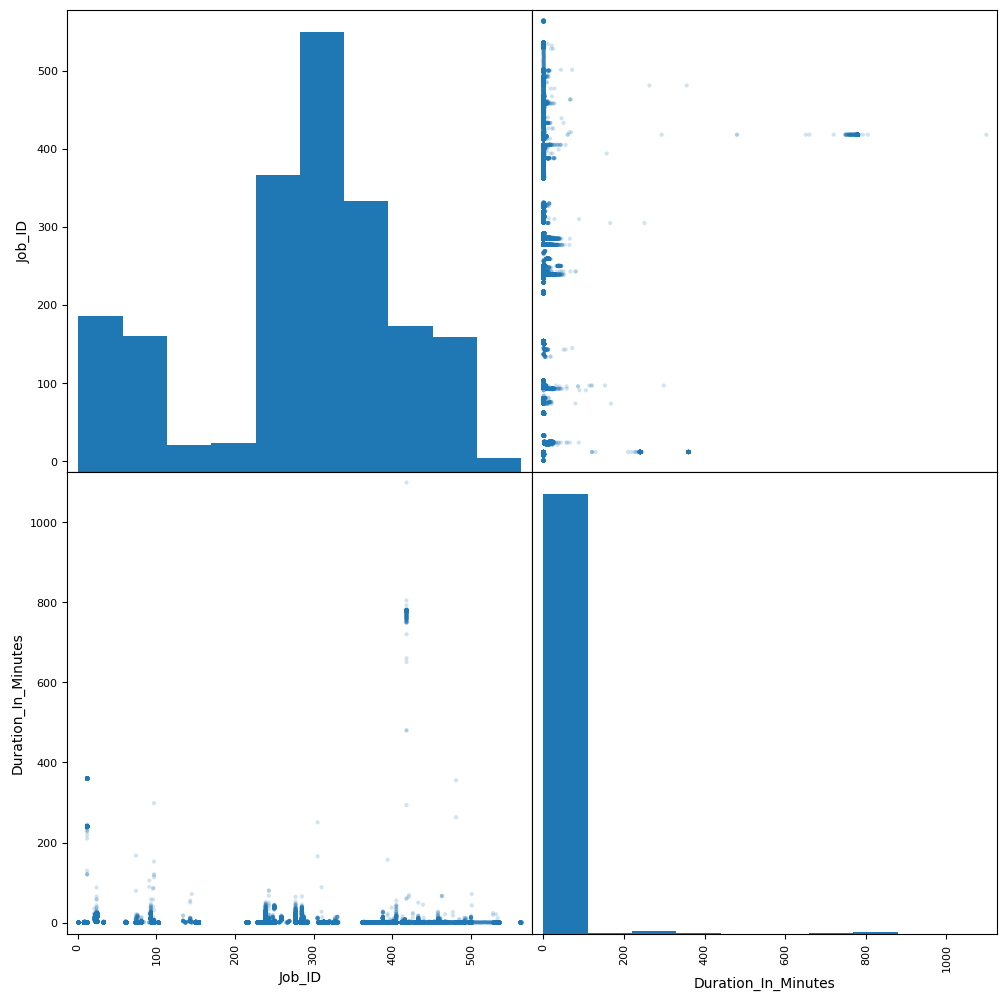

In [69]:
# Scatter matrix to visualize the relationship between non-target (i.e., "Churn") features
pd.plotting.scatter_matrix(Batch_data.select_dtypes(include=[np.number]), figsize=(12, 12), alpha=0.2)
plt.show()

This exploration tells us:


*   Some features (the ones with a diagonal line on the scatter matrix) have a correlation of 100% with one another (such as Day Charge and Day Mins, Night Charge and Night Mins)
*   Features like this can cause problems when we train the model later, so we'll remove the "Charge" features

In [70]:
# Drop features for Day Charge, Eve Charge, Night Charge, Intl Charge to remove the 100% correlation issue
# churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [71]:
# One-hot encode the State column so we have 0s and 1s rather than string data
Batch_data_encoded = pd.get_dummies(Batch_data, columns=['Scheduler_Process_Description'])

# 3. Building and Training the Model

In this section, we split the data into training, validation and test sets.  Then we build the model, inputting various parameters.  Finally, we train the model on the training dataset, evaluting it with the validation dataset.

In [78]:
# Split the data into training, validation and test sets

# Randomly shuffle the dataset and split it into training (70%), validation (20%), and testing (10%) sets
train_data, validation_data, test_data = np.split(Batch_data_encoded.sample(frac=1, random_state=1729),
                                                  [int(0.7 * len(Batch_data)), int(0.9 * len(Batch_data))])

In [79]:
# Assuming the last column "Churn?" is the target variable
# Separate the features and the target variable for each dataset
X_train = train_data.drop("Status", axis=1)
y_train = train_data["Status"]
X_val = validation_data.drop("Status", axis=1)
y_val = validation_data["Status"]
X_test = test_data.drop("Status", axis=1)
y_test = test_data["Status"]

# Convert the datasets into DMatrix format for XGBoost
# XGBoost works well with DMatrix, a data structure optimized for both memory efficiency and training speed
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Started: object, Finished: object, Result: object, ExecutionDate: object, BatchType: object, RunBy: object

In [15]:
# Specify parameters for the model
params = {
    'max_depth': 3,  # The maximum depth of the decision tree; can be adjusted (typically ranges 3-10)
    'eta': 0.1,  # The learning rate (how much the model adjusts itself in response to errors); can be adjusted
    'objective': 'binary:logistic',  # We're choosing this because it's a binary problem (customers either churn or they don't)
                                     # Logistic means it will output a probability (the probability that a customer will leave)
    'eval_metric': 'auc',  # Evaluation metrics for validation data, e.g., "auc" or "Area Under the Curve" for binary classification
}
num_rounds = 100  # The number of rounds for boosting


In [16]:
# Train the model using the training dataset and evaluate it using the validation dataset
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_rounds, evallist)

[0]	eval-auc:0.79041	train-auc:0.84783
[1]	eval-auc:0.79017	train-auc:0.84931
[2]	eval-auc:0.79017	train-auc:0.84932
[3]	eval-auc:0.81304	train-auc:0.87279
[4]	eval-auc:0.84338	train-auc:0.90166
[5]	eval-auc:0.84644	train-auc:0.90539
[6]	eval-auc:0.84819	train-auc:0.90678
[7]	eval-auc:0.84730	train-auc:0.90643
[8]	eval-auc:0.85320	train-auc:0.90922
[9]	eval-auc:0.85490	train-auc:0.91089
[10]	eval-auc:0.85651	train-auc:0.91213
[11]	eval-auc:0.85710	train-auc:0.91321
[12]	eval-auc:0.85804	train-auc:0.91365
[13]	eval-auc:0.85405	train-auc:0.92678
[14]	eval-auc:0.86634	train-auc:0.92544
[15]	eval-auc:0.86711	train-auc:0.92673
[16]	eval-auc:0.86819	train-auc:0.92803


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[17]	eval-auc:0.86900	train-auc:0.92859
[18]	eval-auc:0.86859	train-auc:0.92815
[19]	eval-auc:0.86826	train-auc:0.92838
[20]	eval-auc:0.87059	train-auc:0.93021
[21]	eval-auc:0.87109	train-auc:0.93048
[22]	eval-auc:0.87180	train-auc:0.93095
[23]	eval-auc:0.87204	train-auc:0.93109
[24]	eval-auc:0.87312	train-auc:0.93209
[25]	eval-auc:0.87283	train-auc:0.93228
[26]	eval-auc:0.87435	train-auc:0.93292
[27]	eval-auc:0.87420	train-auc:0.93313
[28]	eval-auc:0.87343	train-auc:0.93313
[29]	eval-auc:0.87277	train-auc:0.93500
[30]	eval-auc:0.87292	train-auc:0.93505
[31]	eval-auc:0.87313	train-auc:0.93516
[32]	eval-auc:0.87377	train-auc:0.93599
[33]	eval-auc:0.87377	train-auc:0.93627
[34]	eval-auc:0.87470	train-auc:0.93642
[35]	eval-auc:0.87435	train-auc:0.93698
[36]	eval-auc:0.87470	train-auc:0.94005
[37]	eval-auc:0.87439	train-auc:0.94011
[38]	eval-auc:0.87484	train-auc:0.94043
[39]	eval-auc:0.87820	train-auc:0.94512
[40]	eval-auc:0.87955	train-auc:0.94718
[41]	eval-auc:0.88028	train-auc:0.94751


AUC values range from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
AUC values between 0.5 and 1.0 indicate useful models. A value of 0.5 suggests a model that does no better than random chance.

Higher AUC values indicate better model performance. In our model, the AUC for both the evaluation set (eval-auc) and the training set (train-auc) increases over the iterations, suggesting the  model is learning and improving its ability to distinguish between the classes over time.


# 4. Evaluating the Model



Initially, the gap between training and evaluation AUC is somewhat moderate, but it starts to widen significantly as training progresses. For instance, towards the end (around iteration 99), the train-auc is at 0.97169 while the eval-auc is at 0.87690. This growing gap may suggest that the model is beginning to overfit the training data-—meaning it's getting better at predicting the training data, but not the evaluation data.  This suggests that the model is fitting more to the idiosyncrasies of the training data rather than capturing generalizable patterns that apply to unseen data.

**Actions to Consider**:

**Early Stopping**: Implement early stopping to halt the training process once the evaluation metric stops improving for a specified number of rounds. XGBoost supports early stopping.

**Regularization**: Increase regularization parameters (lambda, alpha) to penalize more complex models and thus mitigate overfitting.

**Parameter Tuning**: Adjust other hyperparameters, like max_depth, min_child_weight, and subsample, to help control model complexity and fit.

**Cross-Validation**: Use XGBoost's built-in cross-validation method to assess model performance more robustly. This might give you a better indication of how the model will perform on unseen data.

**Feature Engineering**: Revisit your features to ensure they're relevant and not leading to overfitting. Removing irrelevant or highly correlated features can sometimes improve model generalizability.

In [17]:
# Implementing early stopping (i.e., train the model to learn from data until it stops getting better)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Set to a high number intentionally; training may stop much earlier
    evals=[(dval, "eval")],
    early_stopping_rounds=10  # Stops after 10 rounds of no improvement on the eval dataset
)

# After training, you can access the best iteration
# This is the number of the training round where the model performed the best on the validation dataset before it stopped improving
# We'll use this in the next code block
print(f"Best iteration: {bst.best_iteration}")


[0]	eval-auc:0.79041
[1]	eval-auc:0.79017
[2]	eval-auc:0.79017
[3]	eval-auc:0.81304
[4]	eval-auc:0.84338
[5]	eval-auc:0.84644
[6]	eval-auc:0.84819
[7]	eval-auc:0.84730
[8]	eval-auc:0.85320
[9]	eval-auc:0.85490
[10]	eval-auc:0.85651
[11]	eval-auc:0.85710
[12]	eval-auc:0.85804
[13]	eval-auc:0.85405
[14]	eval-auc:0.86634
[15]	eval-auc:0.86711
[16]	eval-auc:0.86819
[17]	eval-auc:0.86900
[18]	eval-auc:0.86859
[19]	eval-auc:0.86826
[20]	eval-auc:0.87059
[21]	eval-auc:0.87109
[22]	eval-auc:0.87180
[23]	eval-auc:0.87204
[24]	eval-auc:0.87312
[25]	eval-auc:0.87283
[26]	eval-auc:0.87435
[27]	eval-auc:0.87420
[28]	eval-auc:0.87343
[29]	eval-auc:0.87277
[30]	eval-auc:0.87292
[31]	eval-auc:0.87313
[32]	eval-auc:0.87377
[33]	eval-auc:0.87377
[34]	eval-auc:0.87470
[35]	eval-auc:0.87435
[36]	eval-auc:0.87470
[37]	eval-auc:0.87439
[38]	eval-auc:0.87484
[39]	eval-auc:0.87820
[40]	eval-auc:0.87955
[41]	eval-auc:0.88028
[42]	eval-auc:0.87992
[43]	eval-auc:0.88043
[44]	eval-auc:0.87994
[45]	eval-auc:0.8813

In [18]:
# Make predictions with the test dataset on the final (best) model

# Predicting the probabilities for the positive class ("Churn")
y_pred_proba = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

# The scikit-learn library is great for calculating AUC and other metrics, though this could also be calculated manually
from sklearn.metrics import roc_auc_score

# Print the final AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Final AUC on Test Dataset: {auc_score:.3f}")

Final AUC on Test Dataset: 0.906


An AUC score of over 0.9 is often considered excellent in many applications. It indicates strong differentiation between the positive and negative classes in the dataset, suggesting that the model has a good predictive ability for the task at hand.